In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import nltk
import spacy
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Sajin.LAPTOP-
[nltk_data]     RE0DL8PH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

target
0    4342
1    3271
Name: count, dtype: int64


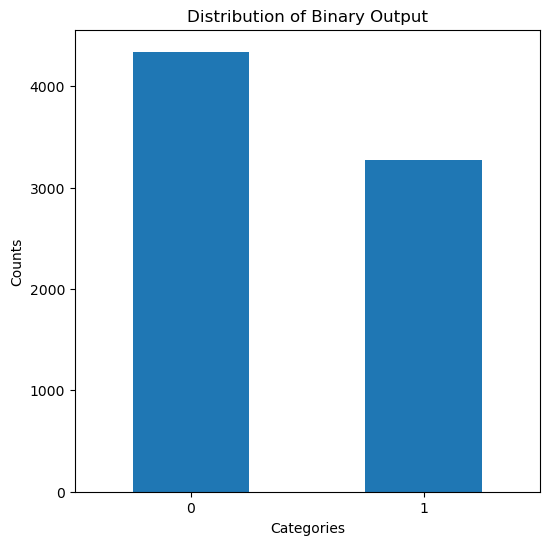

In [3]:
import matplotlib.pyplot as plt

# Calculate counts of each category
counts = train_data['target'].value_counts()
print(counts)

# Plotting
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')
plt.title('Distribution of Binary Output')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.show()

In [4]:
from twitter_clean import clean_text
train_data['clean_text']=train_data['text'].apply(clean_text)
test_data['clean_text']=test_data['text'].apply(clean_text)
train_data.to_csv('train_clean.csv',index=False)
test_data.to_csv('test_clean.csv',index=False)

In [5]:
df_mislabeled = train_data.groupby(['clean_text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
mislabel_txt_list=df_mislabeled.index.tolist()
mislabel_txt_list

['Tanzania elephant population declined by in five years census reveals',
 'Black Eye A space battle occurred at Star involving fleets totaling ships with destroyed',
 'that horrible sinking feeling when you have been at home on your phone for a while and you realise its been on this whole time',
 'Remove the and Linkury Browser Hijacker',
 'GM I pray any attack of the enemy derail your destiny is blocked by the Lord and that He floods your life with heavenly Blessings',
 'Truth News BBC CNN Islam Truth god ISIS terrorism Quran Lies',
 'Bayelsa poll Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP Plans by former First Lady and',
 'I liked a video from GUN RANGE MAYHEM',
 'Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm',
 'To fight bioterrorism sir',
 'Reddit s new content policy goes into effect many horrible subreddits banned or quarantined',
 'STAR WARS POWER OF THE JEDI COLLECTION BATTLE DROID HASBRO Full read by eBay',
 'To a

In [6]:
filtered_df = train_data[train_data['clean_text'].isin(mislabel_txt_list)][['clean_text','target']]
filtered_df

,clean_text,target
246,United States National Park Services Tonto Nat...,0
248,World Annihilation vs Self Transformation Alie...,0
250,United States National Park Services Tonto Nat...,0
251,United States National Park Services Tonto Nat...,1
253,United States National Park Services Tonto Nat...,1
...,...,...
7379,Texas Seeks Comment on Rules for Changes to Wi...,0
7391,TWIA board approves percent rate hike The Texa...,0
7392,Texas Seeks Comment on Rules for Changes to Wi...,0
7396,TWIA board approves percent rate hike The Texa...,1


In [7]:
grouped_mean = filtered_df.groupby('clean_text')['target'].mean().reset_index()
grouped_mean.to_csv('mislabled_correction.csv')

In [8]:
train_data['new_target']=train_data['target'].copy()
for index, row in grouped_mean.iterrows():
    text = row['clean_text']
    target_mean =row['target']
    train_data.loc[train_data['clean_text'] == text, 'new_target'] = 1 if target_mean >= 0.5 else 0
train_data.to_csv('train_new_label.csv',index=False)

In [9]:
counts = train_data['new_target'].value_counts()
print(counts)

new_target
0    4341
1    3272
Name: count, dtype: int64


In [10]:
deduplicated_df = train_data.drop_duplicates(subset=['clean_text'])

# Optionally, reset the index
deduplicated_df = deduplicated_df.reset_index(drop=True)
counts = deduplicated_df['new_target'].value_counts()
print(counts)

new_target
0    4011
1    2795
Name: count, dtype: int64


In [11]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
#wn = nltk.WordNetLemmatizer()
def preprocessing(text):
    
    tokens=word_tokenize(text.lower().strip())
    filtered_tokens=[token for token in tokens if token not in stop_words]
    lemmatized_spacy = [token.lemma_ for token in nlp(" ".join(filtered_tokens))]
#     tokens = [wn.lemmatize(w) for w in word_tokenize(text.lower().strip()) if not w in stop_words]
    return " ".join(lemmatized_spacy)#' '.join(tokens)
deduplicated_df['preprocessed_text']=deduplicated_df['clean_text'].apply(preprocessing)
test_data['preprocessed_text']=test_data['clean_text'].apply(preprocessing)
deduplicated_df.to_csv('train_preprocessed.csv',index=False)
test_data.to_csv('test_preprocessed.csv',index=False)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline
x_train, x_test, y_train, y_test = train_test_split(deduplicated_df['preprocessed_text'],deduplicated_df['new_target'],stratify=deduplicated_df['new_target'],test_size=0.2,random_state=1)
count_vect = CountVectorizer()
tf_transformer = TfidfTransformer(use_idf=False) # just use tf, no idf used

# convert the text list to tfidf form matrix
x_train_counts = count_vect.fit_transform(x_train)
x_train_tf = tf_transformer.fit_transform(x_train_counts)
y_train = np.array(y_train)
clf = BernoulliNB(alpha=0.85, fit_prior=True, class_prior=None)#1.11
clf.fit(x_train_tf, y_train) # train the classifier

# convert list to matrix
x_pre_counts = count_vect.transform(x_test)
x_pre_tf = tf_transformer.transform(x_pre_counts)

predicted = clf.predict(x_pre_tf)

In [13]:
metrics.accuracy_score(list(y_test), predicted)

0.801762114537445

In [14]:
print(classification_report(list(y_test), predicted))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       803
           1       0.87      0.61      0.72       559

    accuracy                           0.80      1362
   macro avg       0.82      0.77      0.78      1362
weighted avg       0.81      0.80      0.79      1362



In [15]:
confusion_matrix(list(y_test), predicted)

array([[752,  51],
       [219, 340]], dtype=int64)

In [16]:
for item in count_vect.get_feature_names_out():
    print(item)

aa
aar
aashiqui
ab
aba
abandon
abbott
abbruchsimulator
abc
abcnews
abe
aberdeen
aberystwyth
abha
abia
ability
abject
ablaze
able
ableg
aboard
abomb
abortion
abouts
abq
absence
absolute
absolutely
abstorm
abstract
absurd
absurdly
abuse
ac
academia
acc
accept
access
accident
accidentally
accidentalprophecy
accord
accordingly
account
accountable
accuracy
accuse
accustomed
acdelco
ace
acenewsdesk
acesse
achedin
achieve
achievement
achimota
acid
acne
acoustic
acquiesce
acquire
acquisition
acre
acronym
across
acrylic
act
actin
action
activate
active
actively
activision
activist
activity
actor
actress
actual
actually
acura
acute
ad
adam
adamantly
adani
adaptation
add
addict
addiction
addition
address
adelaide
adhd
adidas
adiossuperbacteria
adjust
adjustable
adjusted
adjuster
admin
administration
admit
adoption
adoptive
adult
advance
advanced
advantage
adventure
adverse
advertise
advice
advise
advisory
aeg
aeroplane
aerospace
aesthetic
af
afc
affect
affected
affiliate
affiliation
affleck
affli

In [17]:
x_test_counts = count_vect.transform(test_data['preprocessed_text'])
x_test_tf = tf_transformer.transform(x_test_counts)
predicted = clf.predict(x_test_tf)

In [18]:
tem=pd.read_csv('sample_submission.csv')
tem['target']=predicted
tem.to_csv('test_prediction.csv',index=False)

In [19]:
perfect_score=pd.read_csv('submission.csv')
metrics.accuracy_score(list(perfect_score['target']), predicted)

0.7928286852589641

In [20]:
print(classification_report(list(perfect_score['target']), predicted))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      1861
           1       0.85      0.63      0.72      1402

    accuracy                           0.79      3263
   macro avg       0.81      0.77      0.78      3263
weighted avg       0.80      0.79      0.79      3263



In [21]:
print(len(count_vect.get_feature_names_out()))

10168


In [22]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r